# MQ-4

## Ro calculation

### Specifications

#### Standard Work Condition

    Vc (Circuit Voltage)       :  5v +/- 0.1
    Vh (Heating Voltage)       :  5v +/- 0.1
    Rl (Load Resistance)       :  20kOhm
    Rh (Heater Resistance)     :  33Ohm +/- 5%
    Ph (Heating consumption)   :  less than 750mw
    

#### Sensitivity Characteristic:

    Rs (Sensing Resistance)    : 1KOhm  -  60KOhm (1000ppm CH4)
    Preheat Time               : Over 24 hour
    
    Detecting Concentration Scope:
        CH4 and Natural Gas :  200ppm  - 10000ppm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
## Gas concentration values referenced in the datasheet

POINTS = {
    # Liquefied Petroleum Gas
    'lpg' : {
        'p1': {'x': 200,   'y': 2.560},
        'p2': {'x': 1000,  'y': 1.507},
        'p3': {'x': 5000,  'y': 0.900},
        'p4': {'x': 10000, 'y': 0.743}
    },

    # Methane
    'ch4' : {
        'p1': {'x': 200,   'y': 1.753},
        'p2': {'x': 1000,  'y': 1.000},
        'p3': {'x': 5000,  'y': 0.567},
        'p4': {'x': 10000,  'y': 0.438}
    },

    # Hydrogen
    'h2' : {
        'p1': {'x': 200,   'y': 3.761},
        'p2': {'x': 1000,  'y': 2.832},
        'p3': {'x': 5000,  'y': 2.159},
        'p4': {'x': 10000, 'y': 1.891}
    },

    # Carbon Monoxide
    'co' : {
        'p1': {'x': 200,   'y': 4.267},
        'p2': {'x': 1000,  'y': 3.785},
        'p3': {'x': 5000,  'y': 3.622},
        'p4': {'x': 10000, 'y': 3.509}
    },

    'alcohol' : {
        'p1': {'x': 200,   'y': 4.032},
        'p2': {'x': 1000,  'y': 3.622},
        'p3': {'x': 5000,  'y': 3.192},
        'p4': {'x': 10000, 'y': 3.054}
    },

    'smoke' : {
        'p1': {'x': 200,   'y': 3.906},
        'p2': {'x': 1000,  'y': 3.531},
        'p3': {'x': 5000,  'y': 2.886},
        'p4': {'x': 10000, 'y': 2.528}
    }    
}


AIR = 4.432

GASES = ['lpg', 'ch4', 'h2', 'co', 'alcohol', 'smoke']

In [3]:
# RS value calculation
Rs    = lambda Vcc, Vrl, RL : ((Vcc * RL) / Vrl) - RL

# R0 value calculation
R0    = lambda Rs, air : Rs / air

# RS/Ro value calculation (ratio)
Ratio = lambda Rs, R0: Rs / R0

# log(y) = m.log(x) + b
# m
M     = lambda p1, p2 : (math.log10( p2['y'] / p1['y'] )) / (math.log10(p2['x']/p1['x']))
# b
B     = lambda p, m : math.log10(p['y']) - (m * math.log10(p['x']))

# PPM value calculation 
PPM   = lambda  ratio, m, b: 10 ** ((math.log10(ratio) - b) / m)

In [4]:
## Calculate the points to be used for the calculation of _m_ and _b_ according to the _ratio_ value 
def getPoints(racio, values):
    size = len(values)
    for idx in range(size - 1):
        if racio >= values[idx]['y']:
            if idx == 0:
                return (values[0], values[1])
            return(values[idx - 1], values[idx])
    return(values[size - 2], values[size - 1])

In [5]:
pList = {}
for gas in GASES:
    pList[gas] = list(POINTS[gas].values())

In [6]:
col_list = ["date", "mq4_1", "mq4_2"]
df = pd.read_csv('empty_210622_1100.csv', usecols=col_list)

df['date']= pd.to_datetime(df['date'])

mq4_1 = df[["date","mq4_1"]]
mq4_2 = df[["date","mq4_2"]]

### Ro values to be considered

- __Sensor 1__: 8.49 kOhms
- __Sensor 2__: 8.19 kOhms

In [7]:
# MQ 4 - sensor 1
sensor1 = {}
sensor1['Vcc'] = 5      #volts
sensor1['RL']  = 10     #kOhms
sensor1['AIR'] = AIR  
sensor1['Ro']  = 8.09     #kOhms

# MQ 4 - sensor 2
sensor2 = {}
sensor2['Vcc'] = 5      #volts
sensor2['RL']  = 10     #kOhms
sensor2['AIR'] = AIR   
sensor2['Ro']  = 7.73    #kOhms

In [8]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq4_1['mq4_1'].min(),
    mq4_1['mq4_1'].mean(), 
    mq4_1['mq4_1'].quantile(0.25),
    mq4_1['mq4_1'].quantile(0.5),
    mq4_1['mq4_1'].quantile(0.75),
    mq4_1['mq4_1'].max()]

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in Vrl]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

In [9]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max
Vrl = [
    mq4_2['mq4_2'].min(),
    mq4_2['mq4_2'].mean(), 
    mq4_2['mq4_2'].quantile(0.25),
    mq4_2['mq4_2'].quantile(0.5),
    mq4_2['mq4_2'].quantile(0.75),
    mq4_2['mq4_2'].max()]

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in Vrl]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

In [10]:
print(f"Period in which the readings were carried out:\
{mq4_1['date'].min()} - {mq4_1['date'].max()} \n")

print("Sensor 1")


print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor1['Ratio'][0],3),
               round(sensor1['Ratio'][1],3),
               round(sensor1['Ratio'][2],3),
               round(sensor1['Ratio'][3],3),
               round(sensor1['Ratio'][4],3),
               round(sensor1['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm1[gas][0],3),
                   round(ppm1[gas][1],3),
                   round(ppm1[gas][2],3),
                   round(ppm1[gas][3],3),
                   round(ppm1[gas][4],3),
                   round(ppm1[gas][5],3)))
    
print("-"*(12*7))
    
print("Sensor 2")

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor2['Ratio'][0],3),
               round(sensor2['Ratio'][1],3),
               round(sensor2['Ratio'][2],3),
               round(sensor2['Ratio'][3],3),
               round(sensor2['Ratio'][4],3),
               round(sensor2['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm2[gas][0],3),
                   round(ppm2[gas][1],3),
                   round(ppm2[gas][2],3),
                   round(ppm2[gas][3],3),
                   round(ppm2[gas][4],3),
                   round(ppm2[gas][5],3)))

Period in which the readings were carried out:2022-06-21 11:00:00 - 2022-06-21 11:45:00 

Sensor 1
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        1.548        1.519        1.523        1.523        1.511        1.499       
LPG          921.883      976.132      968.346      968.346      992.417      1017.547    
CH4          285.739      301.586      299.314      299.314      306.333      313.511     
H2           28491.62     31439.468    31008.89     31008.89     32347.988    33743.761   
CO           593140867304.264 895278567811.516 845111983820.979 845111983820.979 1008542618654.643 1203406160037.862
ALCOHOL      425259869.096 571324706.457 548179108.887 548179108.887 622280349.763 706326036.374
SMOKE        130293.638   143784.598   141813.979   141813.979   147942.671   154330.949  
------------------------------------------------------------------------------------
Sensor 2
             Min          Mean         1Q      

In [11]:

font = {
    'family': 'serif',
    'color':  'tab:red',
    'weight': 'normal',
    'size': 14
}

font_title = {
    'family': 'serif',
    'color':  'tab:blue',
    'weight': 'normal',
    'size': 16,
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray','tab:olive','tab:cyan']

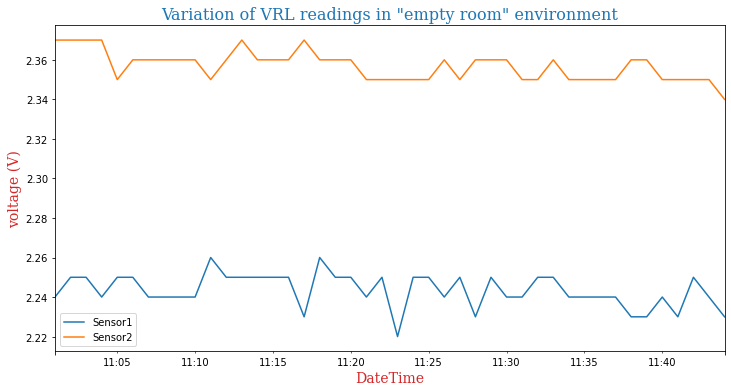

In [12]:
fdf = df[(df['date'] > '6/21/22 11:00 AM') & (df['date'] < '6/21/22 11:45 AM')]

ax = fdf.plot(x='date', y=["mq4_1","mq4_2"], 
              kind="line", figsize=(12, 6))

plt.title('Variation of VRL readings in "empty room" environment', fontdict=font_title)
plt.xlabel('DateTime',    fontdict=font)
plt.ylabel('voltage (V)', fontdict=font)
plt.legend(['Sensor1', 'Sensor2'], loc='best')


plt.show()

In [13]:
# MQ 4 Sensor1

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in mq4_1["mq4_1"]]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

for gas in GASES:
    mq4_1[gas] = ppm1[gas]

In [14]:
# MQ 4 Sensor 2

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in mq4_2["mq4_2"]]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]
   
ppm2 = {}
for gas in GASES:
    ppm2[gas] = []
    
for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))
        
for gas in GASES:
    mq4_2[gas] = ppm2[gas]

In [15]:
mq4_1.describe()

,mq4_1,lpg,ch4,h2,co,alcohol,smoke
count,46.000000,46.000000,46.000000,46.000000,4.600000e+01,4.600000e+01,46.000000
mean,2.243261,976.363497,301.643750,31459.789451,9.054133e+11,5.746595e+08,143877.673197
std,0.008706,20.816536,6.060474,1148.531782,1.348783e+11,6.192633e+07,5256.466495
min,2.220000,921.882872,285.738778,28491.619884,5.931409e+11,4.252599e+08,130293.637718
25%,2.240000,968.345758,299.314480,31008.889819,8.451120e+11,5.481791e+08,141813.978917
50%,2.240000,968.345758,299.314480,31008.889819,8.451120e+11,5.481791e+08,141813.978917
75%,2.250000,992.416939,306.333240,32347.987751,1.008543e+12,6.222803e+08,147942.671102
max,2.260000,1017.547380,313.510715,33743.761334,1.203406e+12,7.063260e+08,154330.949002


In [16]:
mq4_2.describe()

,mq4_2,lpg,ch4,h2,co,alcohol,smoke
count,46.000000,46.000000,46.000000,46.000000,4.600000e+01,4.600000e+01,46.000000
mean,2.356522,1125.239712,343.849543,39945.182742,2.453252e+12,1.175064e+09,182716.356891
std,0.007664,21.628912,6.069124,1286.803629,3.322821e+11,1.138856e+08,5890.357508
min,2.340000,1079.392890,330.966744,37249.090367,1.819277e+12,9.500054e+08,170375.224783
25%,2.350000,1106.799802,338.676032,38846.850086,2.168569e+12,1.077524e+09,177688.717600
50%,2.360000,1134.888899,346.561051,40512.324503,2.584705e+12,1.222086e+09,185312.396695
75%,2.360000,1134.888899,346.561051,40512.324503,2.584705e+12,1.222086e+09,185312.396695
max,2.370000,1163.677756,354.625981,42248.405633,3.080451e+12,1.385963e+09,193259.519453


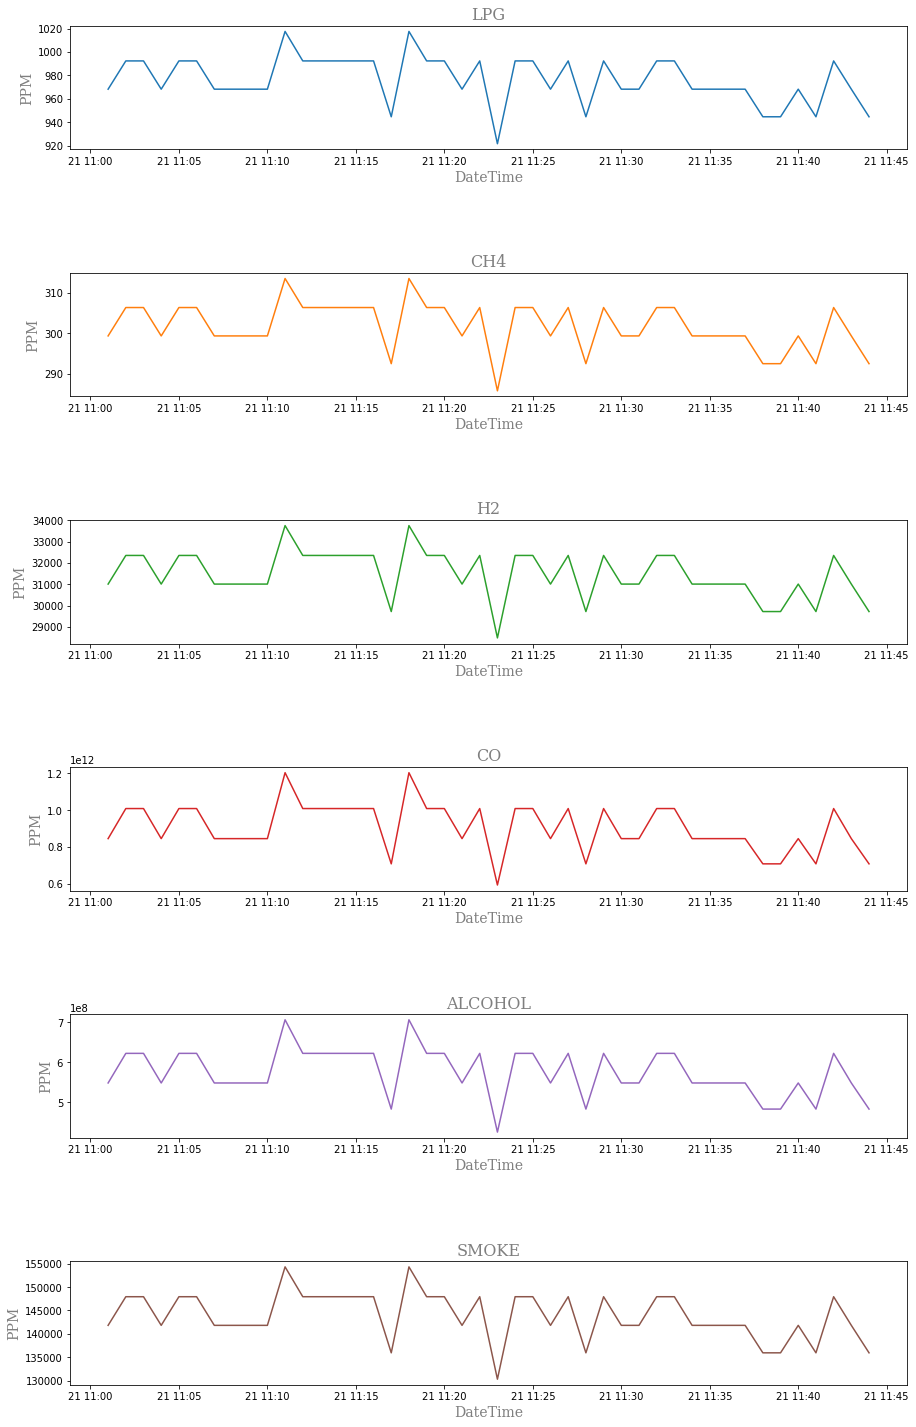

In [17]:
# Time Interval:
#           min: 2022-06-21 11:00:00
#           max: 2022-06-21 11:45:00 
  
fmq = mq4_1[(mq4_1['date'] > '6/21/22 11:00 AM') & (mq4_1['date'] < '6/21/22 11:45 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()


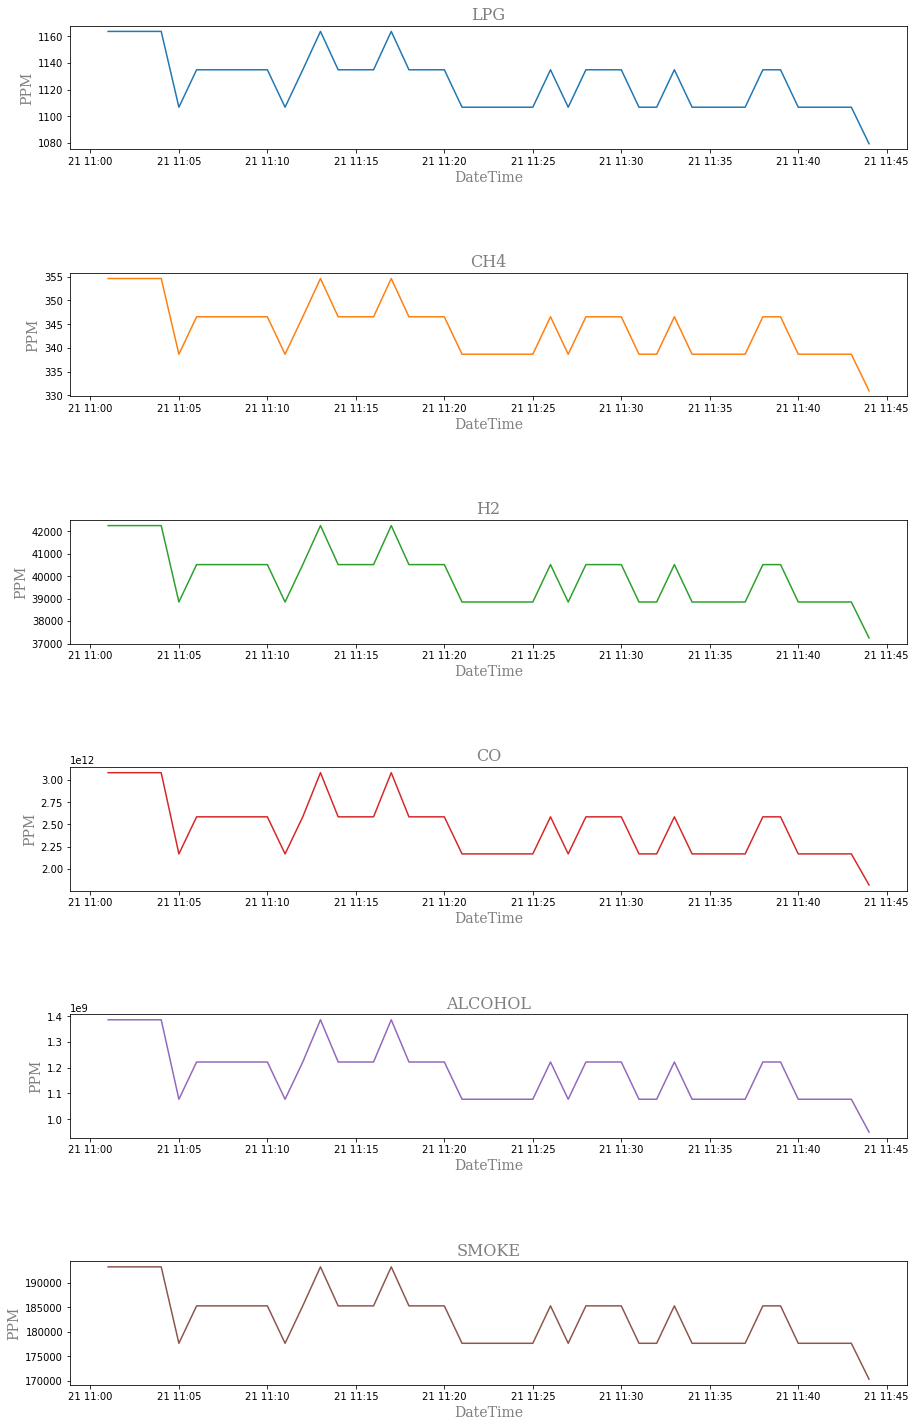

In [18]:
# Time Interval:
#           min: 2022-06-21 11:00:00
#           max: 2022-06-21 11:45:00 
  
fmq = mq4_2[(mq4_2['date'] > '6/21/22 11:00 AM') & (mq4_2['date'] < '6/21/22 11:45 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()


In [19]:
# Save in excel file
mq4_1.to_csv('mq4_1.csv')
mq4_2.to_csv('mq4_2.csv')